In [1]:
# Importing Libraries
import pandas as pd
import datetime
import matplotlib.pyplot as plt


In [3]:
# File Read abd initizaling 
df = pd.read_excel("Covid_Data.xlsx",index_col=0)
df.tail(15)

,Deaths_In_Pakistan
Date,
2021-04-16,112
2021-04-17,149
2021-04-18,73
2021-04-19,137
2021-04-20,147
2021-04-21,98
2021-04-22,144
2021-04-23,157
2021-04-24,118


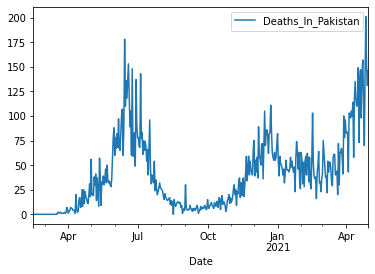

In [4]:
# Plotting our dataframe
df.plot()

# **AR MODEL (Autoregressive model)**

In [5]:
# An autoregressive (AR) model predicts future behavior based on past behavior.
# It's used for forecasting when there is some correlation between values in a
# time series and the values that precede and succeed them.
X = df.values
X.size

441

In [6]:
# splitting test data and train data 265
train = X[0:264]
test = X[264:]
predictions = []
test.size

177

In [8]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
model_ar = AR(train)
model_ar_fit = model_ar.fit()

In [9]:
# start=len(train), end=len(train)+len(test)-1
predictions = model_ar_fit.predict(start=264,end=440) 

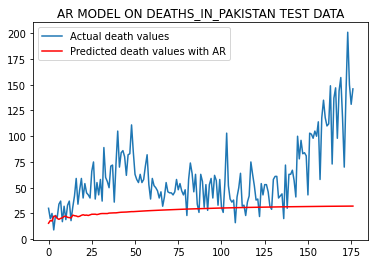

In [10]:
plt.plot(test,label='Actual death values')
plt.plot(predictions, color='red',label='Predicted death values with AR')
plt.title("AR MODEL ON DEATHS_IN_PAKISTAN TEST DATA")
plt.legend()
plt.show()

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

# Mean Absolute Percentage Error (MAPE) is a statistical measure to define the accuracy
# of a machine learning algorithm on a particular dataset.
# (|actual – prediction| / |actual|) * 100
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

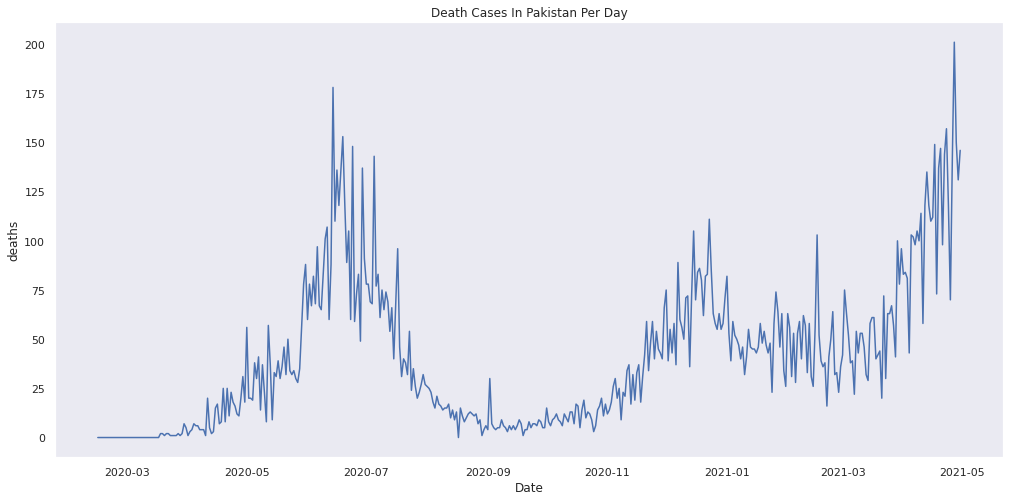

In [12]:
plt.figure(figsize=(17, 8))
plt.plot(df.Deaths_In_Pakistan)
plt.title('Death Cases In Pakistan Per Day')
plt.ylabel('deaths')
plt.xlabel('Date')
plt.grid(False)
plt.show()

# **MOVING AVERAGE (MA)**

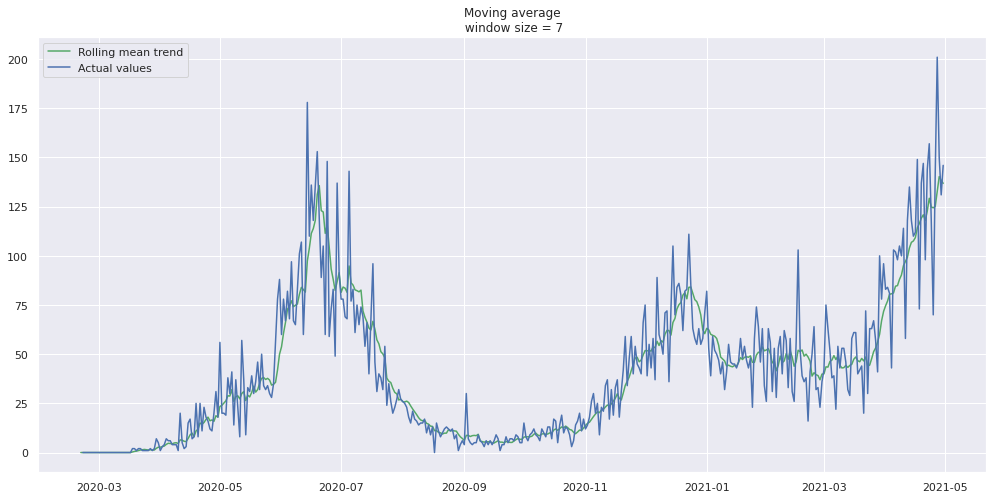

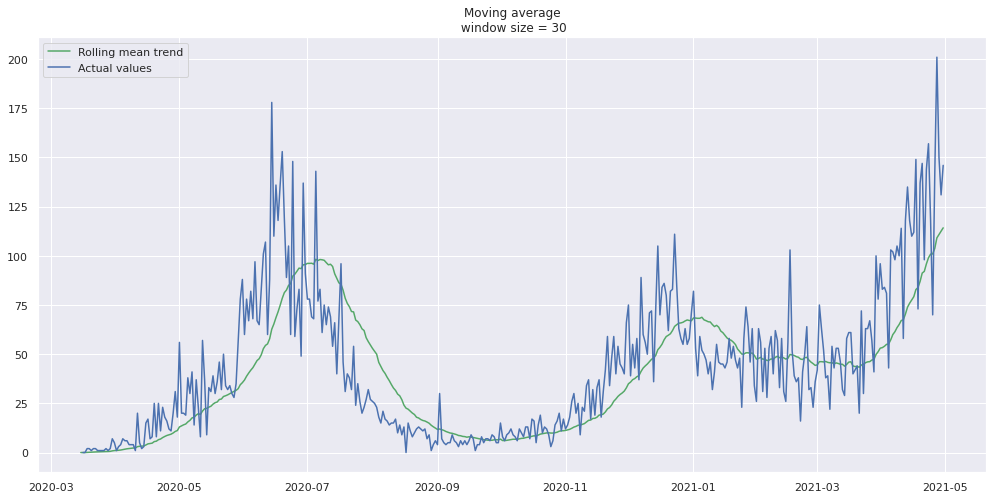

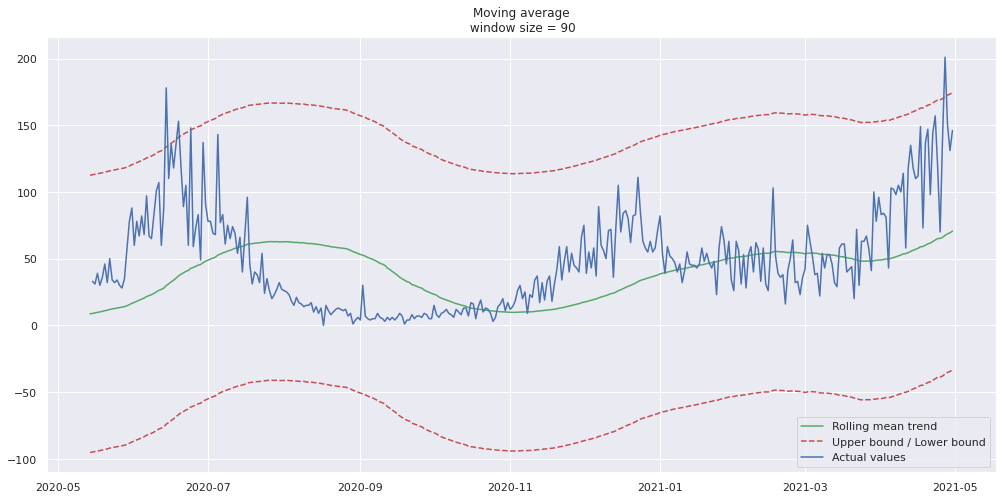

In [13]:
# Rather than using past values of the forecast variable in a regression, a moving
# average model uses past forecast errors in a regression-like model. ... 
# A moving average model is used for forecasting future values, while moving 
# average smoothing is used for estimating the trend-cycle of past values.

def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
#Smooth by the previous 7 days (by week)
plot_moving_average(df.Deaths_In_Pakistan, 7)

#Smooth by the previous month (30 days)
plot_moving_average(df.Deaths_In_Pakistan, 30)

#Smooth by previous quarter (90 days)
plot_moving_average(df.Deaths_In_Pakistan, 90, plot_intervals=True)

# **Stationary and Correlation Check**

# **DICKY - FULLER TEST**

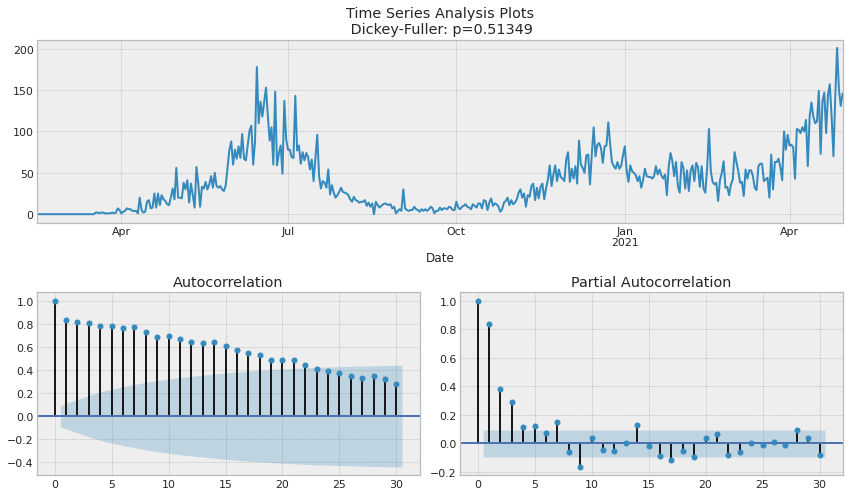

In [14]:
# check if the series is stationary using the Augmented Dickey Fuller test
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(df.Deaths_In_Pakistan, lags=30)

Auto correlation is high a sign of trend season is there and the data is not stationary. p value is close to 1! So lets change the data to stationary like above done difference of 1

**SHIFT DATA TO 1**

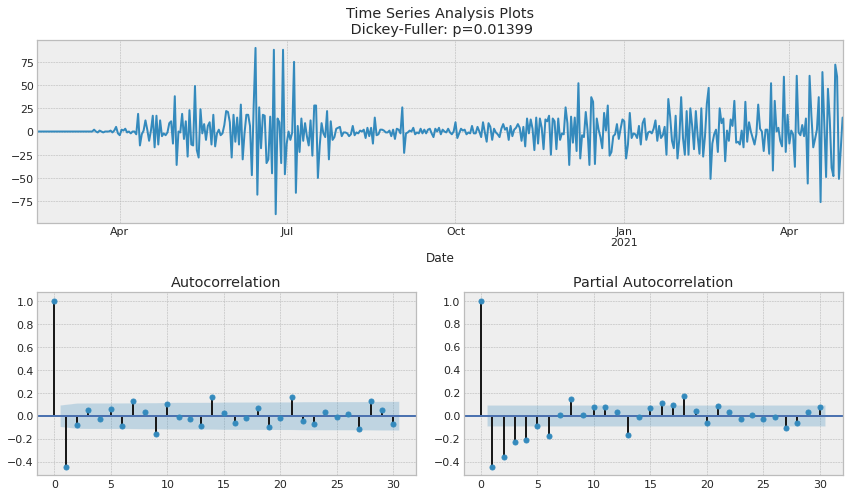

In [15]:
data_diff = df.Deaths_In_Pakistan - df.Deaths_In_Pakistan.shift(1)

tsplot(data_diff[1:], lags=30)

Data is now stationary

## **ARIMA MODELING ON DATA**

In [16]:
 # AutoRegressive Integrated Moving Average



#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Train many SARIMA models to find the best set of parameters
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(df.Deaths_In_Pakistan, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

#Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(df.Deaths_In_Pakistan, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

  0%|          | 0/625 [00:00<?, ?it/s]

                                 Statespace Model Results                                
Dep. Variable:                Deaths_In_Pakistan   No. Observations:                  441
Model:             SARIMAX(3, 1, 4)x(4, 1, 2, 5)   Log Likelihood               -1822.232
Date:                           Mon, 23 May 2022   AIC                           3672.464
Time:                                   21:56:38   BIC                           3729.519
Sample:                               02-15-2020   HQIC                          3694.983
                                    - 04-30-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3984      0.039    -36.106      0.000      -1.474      -1.322
ar.L2         -1.4196      0.020    -70.304

# **TEST DATA AND PREDICTED DATA**

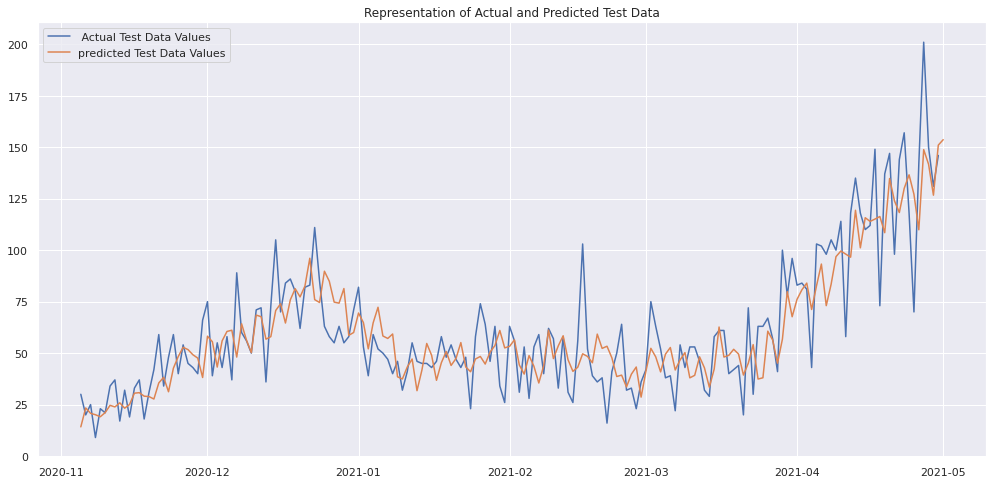

Mean absoulte percentage error (MAPE) of the best model is 27 percent, which is not bad and is usable 


In [ ]:
predictions = best_model.predict(start=264,end=441)

X=df.Deaths_In_Pakistan
test=X[264:]

import numpy as np

mape = np.mean(np.abs((test-predictions) / test)) * 100



plt.figure(figsize=(17, 8))
plt.title('Representation of Actual and Predicted Test Data')
plt.plot(test,label=' Actual Test Data Values')
plt.plot(predictions, label='predicted Test Data Values')
plt.legend()
plt.show()
print("Mean absoulte percentage error (MAPE) of the best model is %d percent, which is not bad and is usable " %(round(mape,2)))


# **Actual Data and Predicted Data**

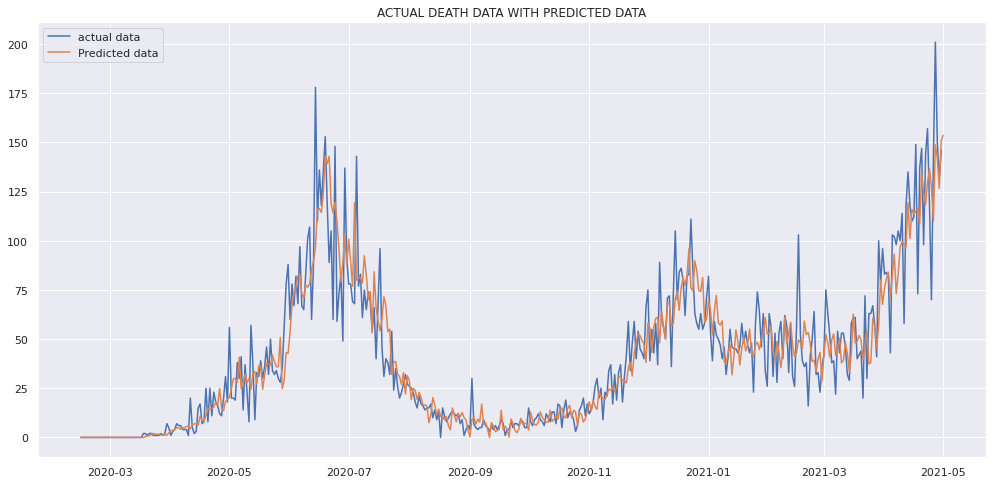

In [ ]:
predictions = best_model.predict(start=0,end=441)
X=df.Deaths_In_Pakistan
plt.figure(figsize=(17, 8))
plt.plot(X,label='actual data')
plt.title("ACTUAL DEATH DATA WITH PREDICTED DATA")
plt.plot(predictions,label='Predicted data')
plt.legend()
plt.show()


# **Prediction Using Best Model**

2021-04-30    151.014159
2021-05-01    153.648937
2021-05-02    146.797229
2021-05-03    145.766267
2021-05-04    170.251518
2021-05-05    148.530276
2021-05-06    133.993203
2021-05-07    173.865160
2021-05-08    160.194161
2021-05-09    133.271382
2021-05-10    148.355665
2021-05-11    172.302211
2021-05-12    161.170303
2021-05-13    149.500768
2021-05-14    167.860343
2021-05-15    162.302391
2021-05-16    144.892852
2021-05-17    168.311548
2021-05-18    177.073822
2021-05-19    154.516958
2021-05-20    152.309488
Freq: D, dtype: float64

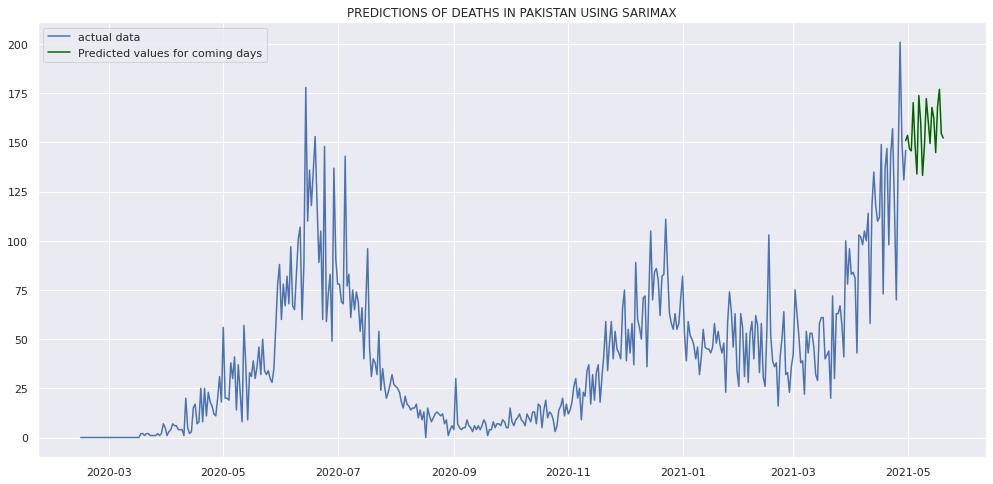

In [ ]:
plt.figure(figsize=(17, 8))
plt.plot(df, label='actual data')
plt.title("PREDICTIONS OF DEATHS IN PAKISTAN USING SARIMAX")
predictions = best_model.predict(start=440,end=460)
plt.plot(predictions, color='darkgreen', label='Predicted values for coming days')
plt.legend()
predictions